In [1]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [2]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [3]:
from malaya_speech.train.model import aligner, fastspeech, tacotron2
import malaya_speech
import tensorflow as tf
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
# phonemes = tf.placeholder(tf.int32, [None, None])
# lens = tf.placeholder(tf.int32, [None])
# mels = tf.placeholder(tf.float32, [None, None, 80])
# mel_lengths = tf.placeholder(tf.int32, [None])

In [5]:
config = malaya_speech.config.fastspeech_config
config['output_attentions'] = True
config = fastspeech.Config(vocab_size = 100, **config)

In [6]:
from malaya_speech.train.model.fastspeech import model_aligner
model = model_aligner.Aligner(config)

In [7]:
phonemes = [[6,7,8,9]]
mels = tf.random.normal(shape = (1, 50, 80))
mel_lengths = [50]
lens = [4]

In [15]:
g = tacotron2.generate_guided_attention(
    mel_lengths[0], lens[0]
)
g = tf.expand_dims(tf.transpose(g), 0)
g.shape

TensorShape([Dimension(1), Dimension(50), Dimension(4)])

In [16]:
mels_output, attentions = model(phonemes, 1 - g, mels, mel_lengths)
mels_output.shape, attentions[-1].shape

(TensorShape([Dimension(1), Dimension(50), Dimension(80)]),
 TensorShape([Dimension(1), Dimension(1), Dimension(50), Dimension(4)]))

In [17]:
attn = tf.transpose(attentions[-1][:,0], [0, 2, 1])
attn.shape

TensorShape([Dimension(1), Dimension(4), Dimension(50)])

In [18]:
mae = tf.losses.absolute_difference
max_length = tf.cast(tf.reduce_max(mel_lengths), tf.int32)
mask = tf.sequence_mask(
    lengths=mel_lengths, maxlen=max_length, dtype=tf.float32
)
mask = tf.expand_dims(mask, axis=-1)
mel_loss = mae(
    labels=mels, predictions=mels_output, weights=mask
)
mel_loss

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=1953, shape=(), dtype=float32, numpy=1.2724807>

In [19]:
g = tacotron2.generate_guided_attention(
    mel_lengths[0], lens[0]
)
g = tf.expand_dims(g, 0)
g.shape

TensorShape([Dimension(1), Dimension(4), Dimension(50)])

In [20]:
attention_masks = tf.cast(tf.math.not_equal(g, -1.0), tf.float32)
loss_att = tf.reduce_sum(
    tf.abs(attn * g) * attention_masks, axis=[1, 2]
)
loss_att /= tf.reduce_sum(attention_masks, axis=[1, 2])
loss_att = tf.reduce_mean(loss_att)
loss_att

<tf.Tensor: id=2006, shape=(), dtype=float32, numpy=0.02325171>

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(mel_loss + loss_att)

RuntimeError: `loss` passed to Optimizer.compute_gradients should be a function when eager execution is enabled.

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)

In [ ]:
data.keys()

In [ ]:
l_text = data['len_text_ids'][0,0]
l_mel = data['len_mel'][0,0]
l_text, l_mel

In [ ]:
o = sess.run(attn, feed_dict = {phonemes: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mels: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0]})
o.shape

In [ ]:
for no in range(100):
    o = sess.run([mel_loss, loss_att, optimizer], feed_dict = {phonemes: data['text_ids'],
                                                        lens: data['len_text_ids'][:,0],
                                                        mels: data['mel'],
                                                        mel_lengths: data['len_mel'][:,0]})
    print(no, o)

In [ ]:
o = sess.run(tf.abs(attn * g), feed_dict = {phonemes: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mels: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0]})
o.shape

In [ ]:
o = sess.run(attn, feed_dict = {phonemes: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mels: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0]})
o.shape

In [ ]:
o = sess.run(g, feed_dict = {phonemes: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mels: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0]})
o.shape

In [22]:
attn

<tf.Tensor: id=1906, shape=(1, 4, 50), dtype=float32, numpy=
array([[[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         

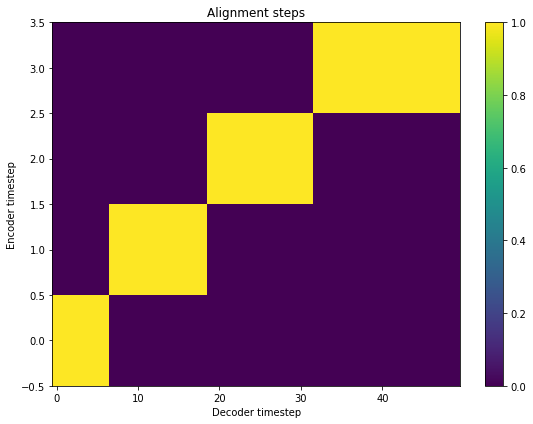

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    attn[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
o[0][0,0].shape

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[2][0,0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
tf.trainable_variables()

In [ ]:
g = tacotron2.generate_guided_attention(
        mel_len, input_len, reduction_factor=reduction_factor
    )

In [ ]:
g = sess.run(tacotron2.generate_guided_attention(800, 40))
g.shape

In [ ]:
g[0]

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    g,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'test/model.ckpt')

In [ ]:
!ls -lh test
!rm -rf test